# Check if class names' vectors can be used for classification
## Qualitative evaluation

Look at the text-vector/class-vector and class-vector/class-vector similarities

In [23]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import class_attention as cat

In [2]:
data = load_dataset("Fraser/news-category-dataset")
data

Using custom data configuration default
Reusing dataset news_category (/Users/vladislavlialin/.cache/huggingface/datasets/news_category/default/0.0.0/737b7b6dff469cbba49a6202c9e94f9d39da1fed94e13170cf7ac4b61a75fb9c)


DatasetDict({
    train: Dataset({
        features: ['category_num', 'category', 'headline', 'authors', 'link', 'short_description', 'date'],
        num_rows: 160682
    })
    test: Dataset({
        features: ['category_num', 'category', 'headline', 'authors', 'link', 'short_description', 'date'],
        num_rows: 30128
    })
    validation: Dataset({
        features: ['category_num', 'category', 'headline', 'authors', 'link', 'short_description', 'date'],
        num_rows: 10043
    })
})

In [3]:
all_classes = data['train'].features['category_num'].names
all_classes = [c.lower() for c in all_classes]
print(all_classes)

['politics', 'wellness', 'entertainment', 'travel', 'style & beauty', 'parenting', 'healthy living', 'queer voices', 'food & drink', 'business', 'comedy', 'sports', 'black voices', 'home & living', 'parents', 'the worldpost', 'weddings', 'women', 'impact', 'divorce', 'crime', 'media', 'weird news', 'green', 'worldpost', 'religion', 'style', 'science', 'world news', 'taste', 'tech', 'money', 'arts', 'fifty', 'good news', 'arts & culture', 'environment', 'college', 'latino voices', 'culture & arts', 'education']


In [377]:
for class_ in all_classes:
    for i, line in enumerate(data['train']):
        if i < 4000:
            continue

        if line['category'].lower() != class_:
            continue
        print(f"{line['category']}: \t {line['headline']}")
        break

POLITICS: 	 ACLU Files FOIA Demanding Facts Behind Donald Trump's Voter Fraud Claim
WELLNESS: 	 Entrepreneurs Are Healthier, Report Finds
ENTERTAINMENT: 	 'Insurgent' Has Officially Been Given The Green Light For 2015, Not That You Had Any Doubts
TRAVEL: 	 Hotels Where The Stars Live (PHOTOS)
STYLE & BEAUTY: 	 Love, Courage and Contentmode
PARENTING: 	 Parenting Gets Hate Mail From 7-Year-Old Girl
HEALTHY LIVING: 	 The Way You Eat -- Not The Food Itself -- Could Influence Weight Gain
QUEER VOICES: 	 Why Doesn't The Trans Community Have A Proper Dating App Yet?
FOOD & DRINK: 	 How To Make Cocktails Without A Recipe
BUSINESS: 	 James Street, All-American Businessman
COMEDY: 	 Seth Meyers Is Ticked That We're Talking Hillary Clinton Emails Again
SPORTS: 	 Kareem Abdul-Jabbar Speaks Out Against Ben Carson's Anti-Muslim Comments
BLACK VOICES: 	 Danny Glover: There's 'Great Opportunity' To Take Progressive Action To A New Level
HOME & LIVING: 	 LED Christmas Lights Might Be One Of The Best D

In [36]:
MODEL = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'h.12.attn.masked_bias', 'h.13.attn.masked_bias', 'h.14.attn.masked_bias', 'h.15.attn.masked_bias', 'h.16.attn.masked_bias', 'h.17.attn.masked_bias', 'h.18.attn.masked_bias', 'h.19.attn.masked_bias', 'h.20.attn.masked_bias', 'h.21.attn.masked_bias', 'h.22.attn.masked_bias', 'h.23.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
tokenizer.batch_decode(tokenizer(all_classes)['input_ids'])

['politics',
 'wellness',
 'entertainment',
 'travel',
 'style & beauty',
 'parenting',
 'healthy living',
 'queer voices',
 'food & drink',
 'business',
 'comedy',
 'sports',
 'black voices',
 'home & living',
 'parents',
 'the worldpost',
 'weddings',
 'women',
 'impact',
 'divorce',
 'crime',
 'media',
 'weird news',
 'green',
 'worldpost',
 'religion',
 'style',
 'science',
 'world news',
 'taste',
 'tech',
 'money',
 'arts',
 'fifty',
 'good news',
 'arts & culture',
 'environment',
 'college',
 'latino voices',
 'culture & arts',
 'education']

In [18]:
def _postprocess_model_output(model_output):
    if isinstance(model_output, tuple):
        hs = model_output[0]
    elif isinstance(model_output, (transformers.modeling_outputs.BaseModelOutput,
                                   transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions,
                                   transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions,)):
        hs = model_output.last_hidden_state
    else:
        raise ValueError(model_output)

    assert isinstance(hs, torch.Tensor)
    assert len(hs.shape) == 3
    return hs

def aggregate_via_cls_token(model_output):
    hs = _postprocess_model_output(model_output)
    cls_tokens = hs[:, 0]
    return cls_tokens

def aggregate_via_maxpool(model_output):
    hs = _postprocess_model_output(model_output)
    maxpooled, _ = torch.max(hs, dim=1)
    return maxpooled

def aggregate_via_meanpool(model_output):
    hs = _postprocess_model_output(model_output)
    meanpooled = torch.mean(hs, dim=1)
    return meanpooled

def remove_highest_principial_component(vecs, remove_n=1):
    """Leaves the dimensionality the same, but zeroes the direction corresponding to the highest singular value eigenvector.
    
    U, S, V = PCA(A)
    A = U @ diag(S) @ V.T
    
    S is a list of singular values, sorted descending.
    """
    U, S, V = torch.pca_lowrank(vecs)
    S_r = S[remove_n:]
    U_r = U[:, remove_n:]
    V_r = V[:, remove_n:]
    
    A_r = U_r @ torch.diag(S_r) @ V_r.T
    return A_r


def remove_smallest_principial_component(vecs, remove_n=1):
    """Leaves the dimensionality the same, but zeroes the direction corresponding to the smallest singular value eigenvector.
    
    U, S, V = PCA(A)
    A = U @ diag(S) @ V.T
    
    S is a list of singular values, sorted descending.
    """
    U, S, V = torch.pca_lowrank(vecs)
    S_r = S[:-remove_n-1]
    U_r = U[:, :-remove_n-1]
    V_r = V[:, :-remove_n-1]
    
    A_r = U_r @ torch.diag(S_r) @ V_r.T
    return A_r


def plot_class_name_similarities(text, agg_fn, classes=None, y_vecs_transformation=None):
    classes = classes or all_classes

    x_ids = tokenizer(text, return_tensors='pt')
    x_vec = model(**x_ids)
    x_vec = agg_fn(x_vec)

    y_ids = tokenizer(classes, padding=True, return_tensors='pt')
    y_vecs = model(**y_ids)
    y_vecs = agg_fn(y_vecs)

    if y_vecs_transformation is not None:
        # we can't do the same thing with the x_vecs, as we need a bunch of them to perform the PCA
        # maybe we can apply the same transformation we apply to the y_vecs? How can we get the transformation matrix? Is it even linear (yes)?
        y_vecs = y_vecs_transformation(y_vecs)
    
#     x_vec = cat.modelling_utils.normalize_embeds(x_vec)
#     y_vecs = cat.modelling_utils.normalize_embeds(y_vecs)

    x_vec = x_vec.squeeze(0)
    scores = x_vec @ y_vecs.T

    p = torch.softmax(scores, dim=-1)

    plt.figure(figsize=(8, 4))
    plt.title(text)
    plt.xticks(rotation=45)
    plt.bar(classes, p.detach().numpy())
    
    sorted_p, sorted_id = p.sort(descending=True)
    sorted_c = [classes[i] for i in sorted_id]

    print(f"The most likely classes: ")
    for i in range(3):
        print(f"{sorted_c[i]}\t: {sorted_p[i]}")

In [ ]:
text = "Einstein's general relativity predicts a supermassive black hole near Earth"

x_ids = tokenizer(text, return_tensors='pt')
x_vec = model(**x_ids)
x_vec = aggregate_via_cls_token(x_vec).squeeze(0)

classes = ['science', 'sport', 'politics', 'travel', 'divorce', 'crime', 'religion', 'arts']
# classes = ['new article about ' + c for c in classes]

y_ids = tokenizer(
    classes,
    padding=True, return_tensors='pt')
y_vecs = model(**y_ids)
y_vecs = aggregate_via_cls_token(y_vecs)

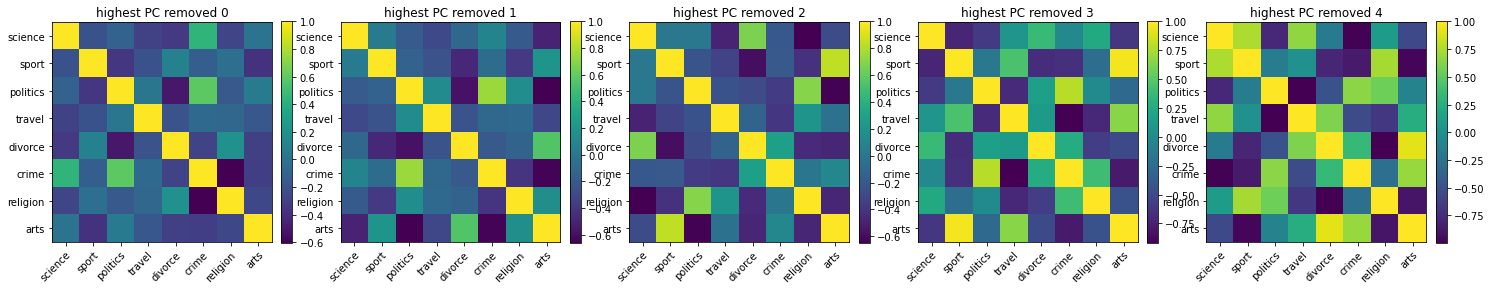

In [409]:
max_k = 5
fig, axs = plt.subplots(1, max_k, figsize=(25, 10))

for k in range(max_k):
    _y_vecs = remove_highest_principial_component(y_vecs, remove_n=k)
    _y_vecs = cat.modelling_utils.normalize_embeds(_y_vecs)
    ax = axs[k]

    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)


    ax.set_title(f'highest PC removed {k}')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    im = ax.imshow((_y_vecs @ _y_vecs.T).detach().numpy())
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

Final clusters:
* science, sport, religion
* politics, travel, divorce, crime, arts

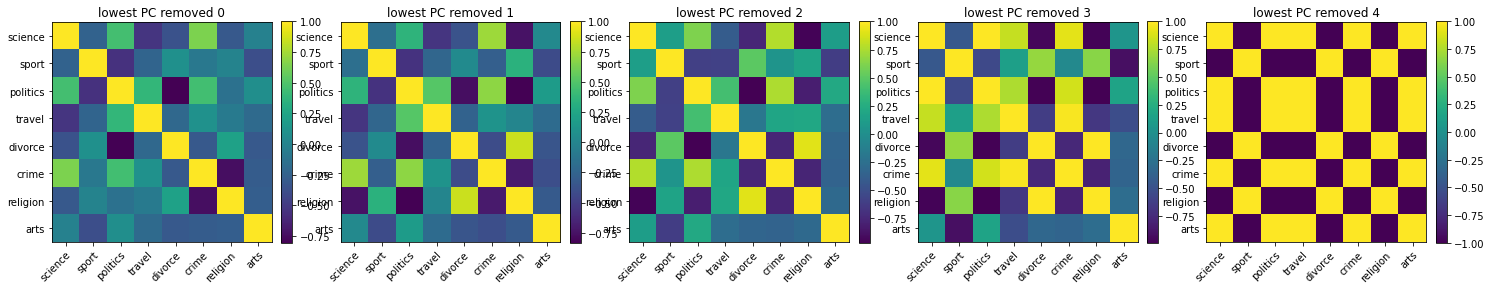

In [410]:
max_k = 5
fig, axs = plt.subplots(1, max_k, figsize=(25, 10))

for k in range(max_k):
    _y_vecs = remove_smallest_principial_component(y_vecs, remove_n=k)
    _y_vecs = cat.modelling_utils.normalize_embeds(_y_vecs)
    ax = axs[k]

    ax.set_xticks(range(len(classes)))
    ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)


    ax.set_title(f'lowest PC removed {k}')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    im = ax.imshow((_y_vecs @ _y_vecs.T).detach().numpy())
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

Final clusters:
* science, politics, divorce, crime, religion
* sport, travel, arts

In [411]:
from functools import partial

Removing 0 highest components
The most likely classes: 
sport	: 0.14068922400474548
religion	: 0.13816656172275543
crime	: 0.1293269842863083

Removing 1 highest components
The most likely classes: 
science	: 0.13558071851730347
religion	: 0.13164842128753662
sport	: 0.13029745221138

Removing 2 highest components
The most likely classes: 
religion	: 0.13494902849197388
science	: 0.13133305311203003
sport	: 0.1295710802078247

Removing 3 highest components
The most likely classes: 
religion	: 0.13769744336605072
politics	: 0.1259305477142334
crime	: 0.12590044736862183

Removing 4 highest components
The most likely classes: 
religion	: 0.13668431341648102
politics	: 0.12762358784675598
crime	: 0.12560129165649414



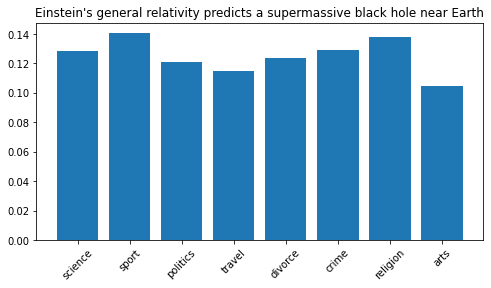

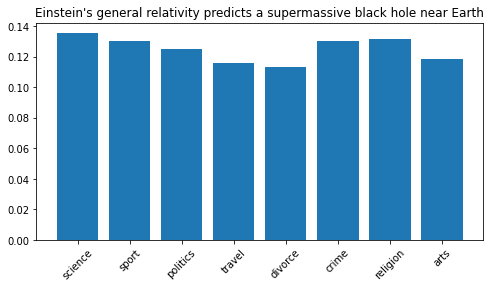

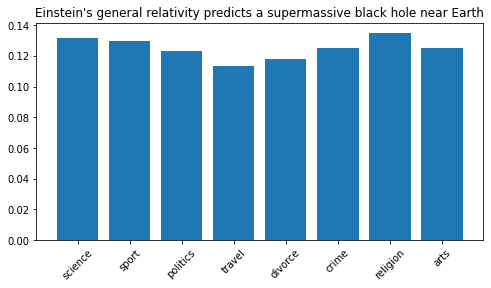

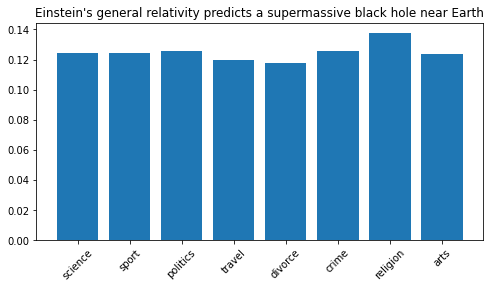

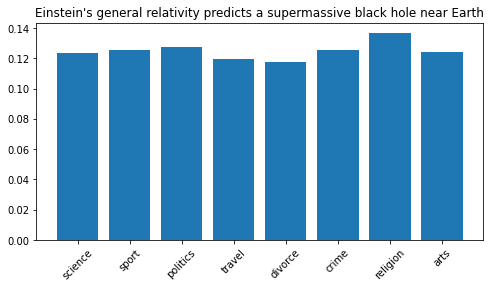

In [412]:
text = "Einstein's general relativity predicts a supermassive black hole near Earth"
classes = ['science', 'sport', 'politics', 'travel', 'divorce', 'crime', 'religion', 'arts']
# classes = ['new article about ' + c for c in classes]

for k in range(5):
    print(f"Removing {k} highest components")
    plot_class_name_similarities(text, aggregate_via_cls_token, classes, y_vecs_transformation=partial(remove_highest_principial_component, remove_n=k))
    print()

Removing 0 highest components
The most likely classes: 
sport	: 0.14160634577274323
divorce	: 0.1355236917734146
crime	: 0.1299450546503067

Removing 1 highest components
The most likely classes: 
science	: 0.1306113302707672
crime	: 0.13049796223640442
sport	: 0.1277671456336975

Removing 2 highest components
The most likely classes: 
crime	: 0.1306266337633133
sport	: 0.12713630497455597
divorce	: 0.12650401890277863

Removing 3 highest components
The most likely classes: 
politics	: 0.12695886194705963
divorce	: 0.12687702476978302
science	: 0.12590542435646057

Removing 4 highest components
The most likely classes: 
divorce	: 0.12754635512828827
politics	: 0.12735675275325775
crime	: 0.12626750767230988



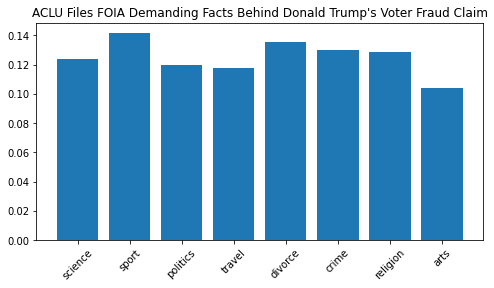

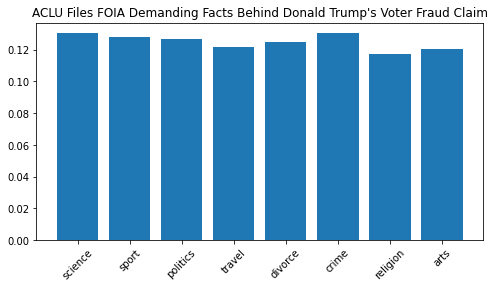

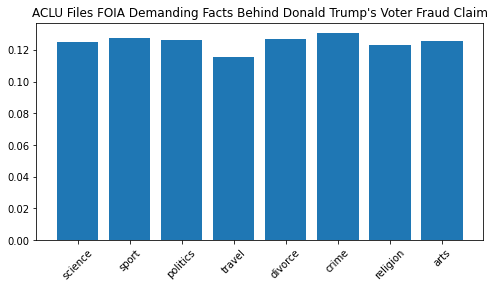

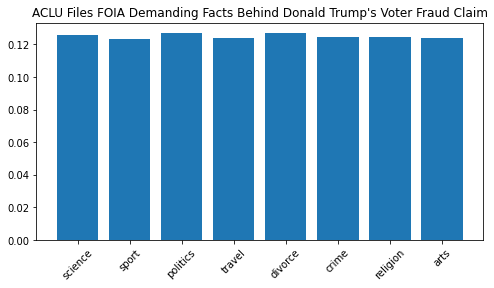

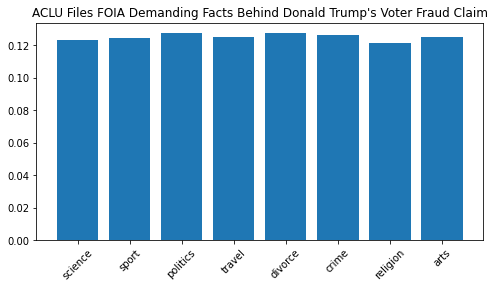

In [413]:
text = "ACLU Files FOIA Demanding Facts Behind Donald Trump's Voter Fraud Claim"
classes = ['science', 'sport', 'politics', 'travel', 'divorce', 'crime', 'religion', 'arts']
# classes = ['new article about ' + c for c in classes]

for k in range(5):
    print(f"Removing {k} highest components")
    plot_class_name_similarities(text, aggregate_via_cls_token, classes, y_vecs_transformation=partial(remove_highest_principial_component, remove_n=k))
    print()


Removing 0 highest components
The most likely classes: 
sport	: 0.1410207897424698
divorce	: 0.1360744833946228
religion	: 0.12708540260791779

Removing 1 highest components
The most likely classes: 
sport	: 0.1412537693977356
divorce	: 0.13532045483589172
crime	: 0.12798050045967102

Removing 2 highest components
The most likely classes: 
sport	: 0.14233452081680298
divorce	: 0.13514602184295654
religion	: 0.12752270698547363

Removing 3 highest components
The most likely classes: 
sport	: 0.13769204914569855
divorce	: 0.13482104241847992
religion	: 0.12989185750484467

Removing 4 highest components
The most likely classes: 
divorce	: 0.13887308537960052
sport	: 0.1366322785615921
religion	: 0.13233059644699097



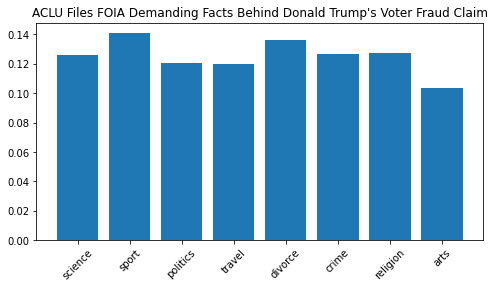

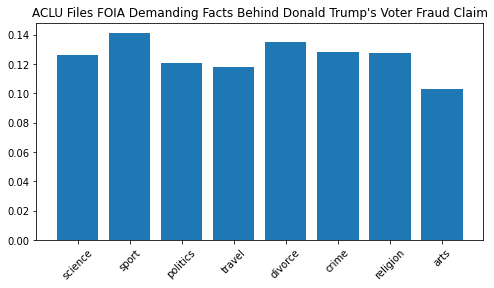

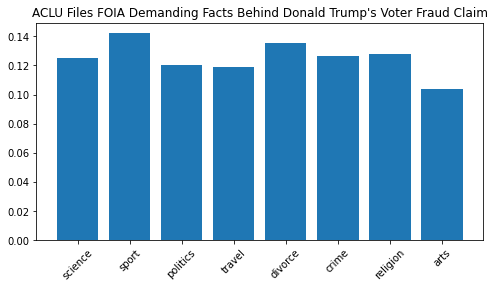

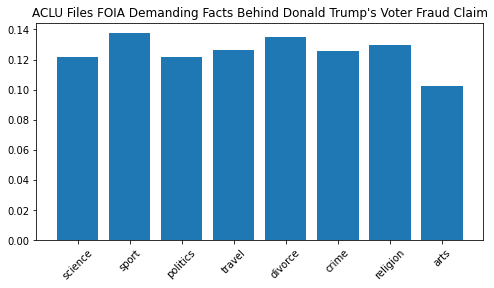

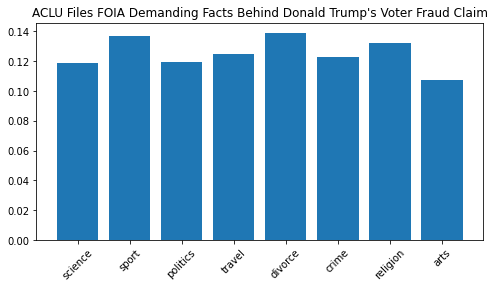

In [414]:
text = "ACLU Files FOIA Demanding Facts Behind Donald Trump's Voter Fraud Claim"
classes = ['science', 'sport', 'politics', 'travel', 'divorce', 'crime', 'religion', 'arts']
# classes = ['new article about ' + c for c in classes]

for k in range(5):
    print(f"Removing {k} highest components")
    plot_class_name_similarities(text, aggregate_via_cls_token, classes, y_vecs_transformation=partial(remove_smallest_principial_component, remove_n=k))
    print()


Removing 0 highest components
The most likely classes: 
Article about science	: 0.12813174724578857
Article about religion	: 0.12679024040699005
Article about travel	: 0.12601815164089203

Removing 1 highest components
The most likely classes: 
Article about religion	: 0.12800754606723785
Article about science	: 0.1276988983154297
Article about divorce	: 0.12508602440357208

Removing 2 highest components
The most likely classes: 
Article about science	: 0.12714830040931702
Article about religion	: 0.12680533528327942
Article about crime	: 0.125785693526268

Removing 3 highest components
The most likely classes: 
Article about science	: 0.12636899948120117
Article about crime	: 0.1258814036846161
Article about travel	: 0.12583157420158386

Removing 4 highest components
The most likely classes: 
Article about divorce	: 0.12660831212997437
Article about religion	: 0.1254412829875946
Article about travel	: 0.12536944448947906



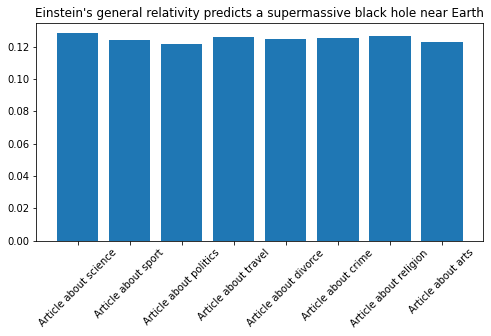

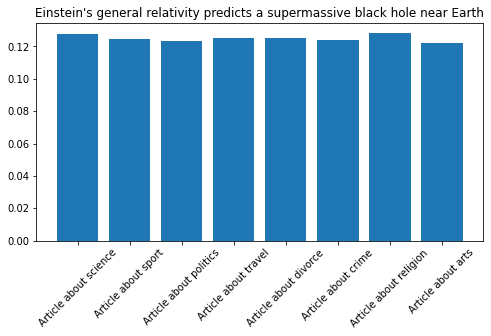

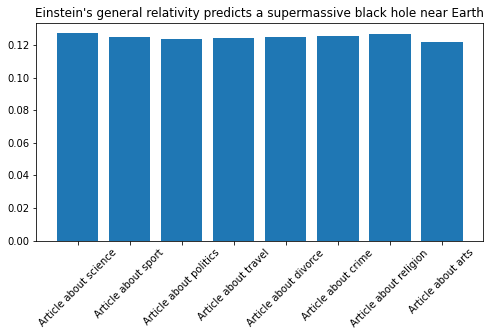

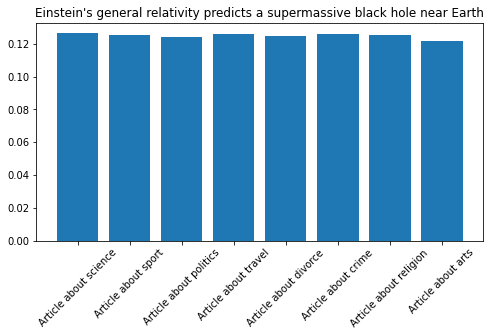

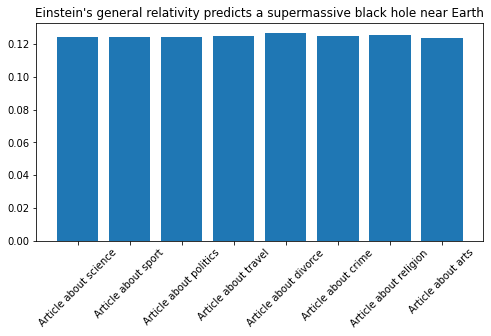

In [415]:
text = "Einstein's general relativity predicts a supermassive black hole near Earth"
classes = ['science', 'sport', 'politics', 'travel', 'divorce', 'crime', 'religion', 'arts']
classes = ['Article about ' + c for c in classes]

for k in range(5):
    print(f"Removing {k} highest components")
    plot_class_name_similarities(text, aggregate_via_cls_token, classes, y_vecs_transformation=partial(remove_smallest_principial_component, remove_n=k))
    print()

The most likely classes: 
weddings	: 0.031221561133861542
travel	: 0.03080136701464653
education	: 0.030520660802721977


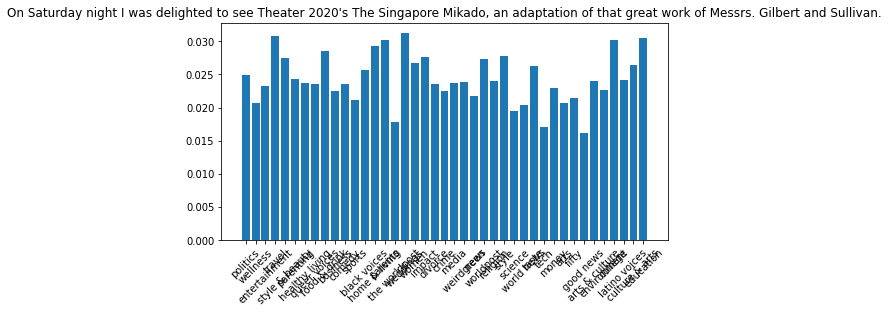

In [416]:
text = "On Saturday night I was delighted to see Theater 2020's The Singapore Mikado, an adaptation of that great work of Messrs. Gilbert and Sullivan."
plot_class_name_similarities(text, aggregate_via_cls_token)

The most likely classes: 
parents	: 0.03723714128136635
women	: 0.03329166769981384
style & beauty	: 0.03194796293973923


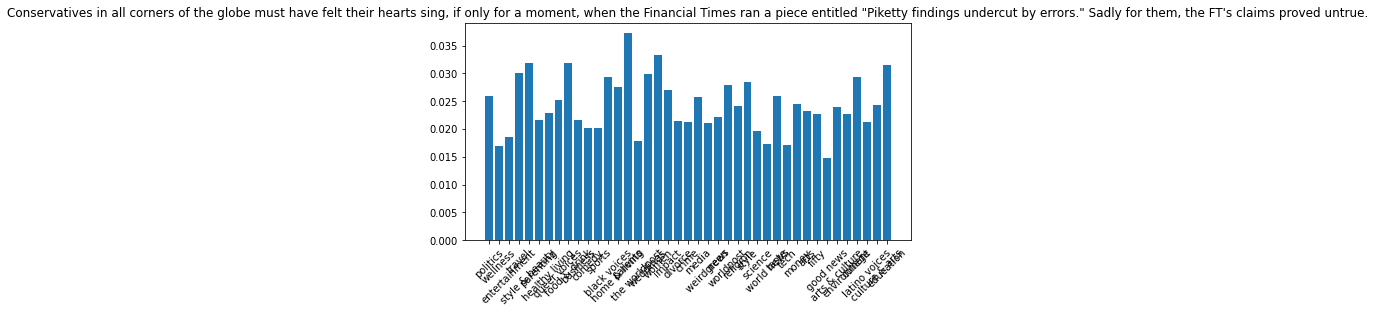

In [417]:
plot_class_name_similarities(
    """Conservatives in all corners of the globe must have felt their hearts sing, if only for a moment, when the Financial Times ran a piece entitled "Piketty findings undercut by errors." Sadly for them, the FT's claims proved untrue.""",
    aggregate_via_cls_token,
)

## Quantitative evaluaiton

Use the raw vectors, without any training as a classifier. Compare with a random baseline.

In [6]:
small_test_set = cat.utils.sample_dataset(data['test'], p=0.1)
small_test_set

Dataset({
    features: ['authors', 'category', 'category_num', 'date', 'headline', 'link', 'short_description'],
    num_rows: 3012
})

In [33]:
accuracies = []

for _ in tqdm(range(50)):

    random_predicitons = np.random.choice(all_classes, size=len(small_test_set))

    n_correct = 0

    for line, pred in zip(small_test_set, random_predicitons):
        if line['category'].lower() == pred:
            n_correct += 1
    
    accuracies.append(n_correct / len(small_test_set))

print(f'Random classifier arrucary: {round(np.mean(accuracies), 3)} ± {round(np.std(accuracies), 3)}')
print(f'Maximum: {round(max(accuracies), 3)}, minimum: {round(min(accuracies), 3)}')

  0%|          | 0/50 [00:00<?, ?it/s]

Random classifier arrucary: 0.025 ± 0.003
Maximum: 0.034, minimum: 0.018


In [26]:
def evaluate(dataset, model_str, agg_fn, classes=None, y_vecs_transformation=None, normalize_x=False, normalize_y=False):
    model = AutoModel.from_pretrained(model_str)
    tokenizer = AutoTokenizer.from_pretrained(model_str)

    classes = classes or all_classes
    class2id = {c: i for i, c in enumerate(classes)}

    y_ids = tokenizer(classes, padding=True, return_tensors='pt')
    y_vecs = model(**y_ids)
    y_vecs = agg_fn(y_vecs)

    if y_vecs_transformation is not None:
        # we can't do the same thing with the x_vecs, as we need a bunch of them to perform the PCA
        # maybe we can apply the same transformation we apply to the y_vecs? How can we get the transformation matrix? Is it even linear (yes)?
        y_vecs = y_vecs_transformation(y_vecs)

    if normalize_y:
        y_vecs = cat.modelling_utils.normalize_embeds(y_vecs)

    n_correct = 0
    predictions = []

    for line in tqdm(dataset):
        text = line['headline']
        target = line['category'].lower()
        target_id = class2id[target]

        x_ids = tokenizer(text, return_tensors='pt')
        x_vec = model(**x_ids)
        x_vec = agg_fn(x_vec)

        if normalize_x:
            x_vec = cat.modelling_utils.normalize_embeds(x_vec)

        x_vec = x_vec.squeeze(0)
        scores = x_vec @ y_vecs.T
        _, pred = torch.max(scores, dim=-1)

        if pred == target_id:
            n_correct += 1
        
        predictions.append(pred.item())

    acc = n_correct / len(dataset)
    return predictions, acc

In [40]:
results = []

# models = ["distilbert-base-uncased", "bert-base-uncased", "bert-large-uncased", "roberta-base", "roberta-large", "google/electra-base-discriminator",
#           "google/electra-large-discriminator", "albert-xxlarge-v2", "xlnet-base-cased", "xlnet-large-cased", "gpt2", "gpt2-medium", "gpt2-large"]
models = ["distilbert-base-uncased", "roberta-base", "roberta-large"]
agg_fns = [aggregate_via_cls_token, aggregate_via_maxpool, aggregate_via_meanpool]

for model_str, agg_fn, normalize_x, normalize_y in tqdm(list(product(
    models, agg_fns, [False, True], [False, True]
))):
    try:
        _, acc = evaluate(small_test_set, model_str, agg_fn, y_vecs_transformation=None, normalize_x=normalize_x, normalize_y=normalize_y)
        results.append({
            "model": model_str,
            "agg_fn": agg_fn.__name__,
            "y_vecs_transformation": None,
            "normalize_x": normalize_x,
            "normalize_y": normalize_y,
        })
    except Exception as e:
        print(e)
        print()

results_df = pd.DataFrame(results)

In [55]:
3 * 3 * 2 * 2

36

In [27]:
preds, acc = evaluate(small_test_set, "distilbert-base-uncased", agg_fn=aggregate_via_cls_token, y_vecs_transformation=None, normalize_x=False, normalize_y=False)
print(acc)

  0%|          | 0/3012 [00:00<?, ?it/s]

0.046812749003984064


In [28]:
preds, acc = evaluate(small_test_set, "distilbert-base-uncased", agg_fn=aggregate_via_maxpool, y_vecs_transformation=None, normalize_x=False, normalize_y=False)
print(acc)

  0%|          | 0/3012 [00:00<?, ?it/s]

0.0073041168658698535
